
Install all packages for the tutorial.

In [1]:
!pip install scanpy==1.4.6 umap-learn==0.4.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas matplotlib scrublet seaborn python-igraph==0.8.0 louvain==0.6.1

Load all required packages.

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os 
#doublet detection
import scrublet as scr


#pretty plotting
import seaborn as sb



/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


scanpy==1.4.6 anndata==0.7.1 umap==0.4.0 numpy==1.18.2 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0 louvain==0.6.1


Of note, this notebook was created as part of a workshop, so we use extra large legend texts in all seaborn plots. You can set the context as well to 'talk' or 'paper'.

In [4]:
sb.set_context(context='poster')


## Set project file paths

Let us set up the connection with Google Drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We set up the file paths to the respective directories.

In [6]:
file_path = '/content/drive/My Drive/' #this is the file path to your google drive (main directory)

File path to the raw data. They are usually stored at a different location than the rest of the project.

In [7]:
file_path_raw = file_path + '3k_PBMC/'

The data directory contains all processed data and `anndata` files. 

In [8]:
data_dir = file_path + 'day1_beginner/data/' 

The tables directory contains all tabular data output, e.g. in `.csv` or `.xls` file format. That applies to differential expression test results or overview tables such as the number of cells per cell type.

In [9]:
table_dir = file_path + 'day1_beginner/tables/'

The default figure path is a POSIX path calles 'figures'. If you don't change the default figure directory, scanpy creates a subdirectory where this notebook is located.  

In [10]:
sc.settings.figdir = file_path + 'day1_beginner/figures/'

**Comment:** When you repeat certain analyses, it might be helpful to set a `date` variable and add it to every figure and table (see `datetime` Python package).

# Read data

The dataset consists of 4k PBMCs (Human) provided by 10X Genomics. The data is an mtx directory with an `mtx` file (*i.e.* count matrix), two `tsv` files with barcodes (*i.e.* cell indices) and features (*i.e.* gene symbols). `Scanpy` unpacks the files (if the files are in `gz` archive format) and creates an `anndata` object with the `read_10x_mtx` function.    

The dataset is not filtered, yet. 

In [11]:
file_path_raw = file_path_raw + 'raw_gene_bc_matrices/'


In [12]:
adata_raw = sc.read_10x_mtx(path=file_path_raw)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Let us check the dataset size. 

In [13]:
adata_raw.shape

(737280, 33694)

In [14]:
print('Total number of observations: {:d}'.format(adata_raw.n_obs))

Total number of observations: 737280


# Pre-processing and visualization

## Remove empty droplets
The dataset contains an excessive amount of "cells", which are in fact empty droplets. Let us remove these barcodes prior to further quality control. In R, there is the emptyDrops package to distinguish empty droplets from actual cells. We do not have access to an R kernel on Google Colabs, therefore, we select all cells with less than 100 counts in total to estimate the background signal.

It must be noted that CellRanger 3.0 has incorporated the EmptyDrops algorithm to distinguish cells from empty droplets.

Let us examine the barcodes with less than 100 counts.

In [15]:
#compute number of total counts
adata_raw.obs['n_counts'] = np.sum(adata_raw.X, axis=1)
adata_empty = adata_raw[adata_raw.obs['n_counts']<100].copy()

Estimate the gene composition in the background. Compute the number of counts per gene over all cells first.

In [16]:
adata_empty.var['total_gene']= np.sum(adata_empty.X, axis=0).A1

Compute the contribution of a gene to the background signal as the total number of counts of a gene over all cells divided by the total number of counts.

In [17]:
filter_bool, _ = sc.pp.filter_cells(adata_raw, min_counts=100, inplace=False)

filtered out 731979 cells that have less than 100 counts


In [18]:
adata = adata_raw[filter_bool].copy()

In [19]:
adata

AnnData object with n_obs × n_vars = 5301 × 33694 
    obs: 'n_counts'
    var: 'gene_ids'

Save the filtered data set to file.

In [20]:
adata.write(data_dir + 'data_filtered.h5ad')

## Quality control

In [21]:
adata = sc.read(data_dir + 'data_filtered.h5ad')

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates: 

* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

Note: mitochondrial genes in human start with 'MT-'

In [22]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

Let us visualize the number of expressed genes and the number of counts as a scatter plot. 

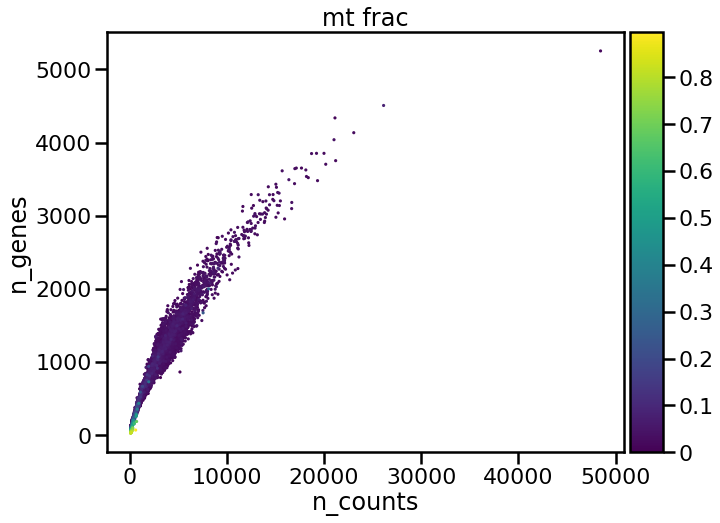

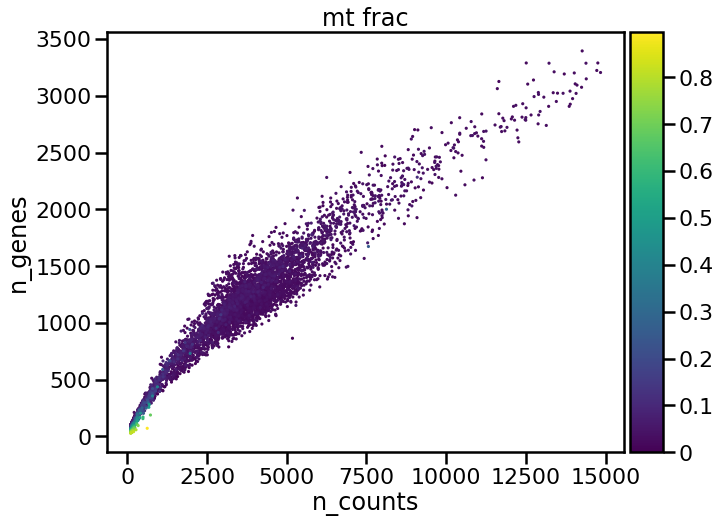

In [23]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes', 
                   color='mt_frac', size=40)

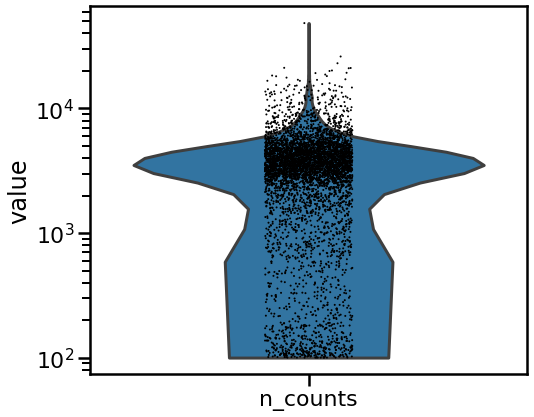

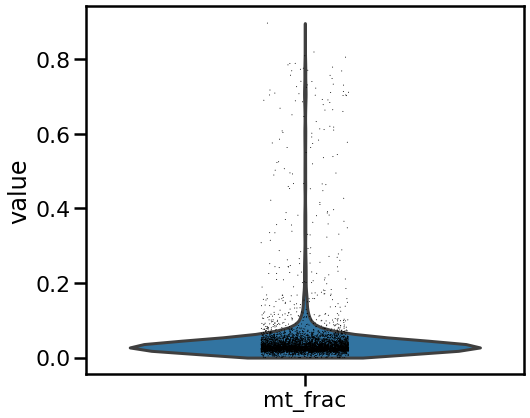

In [24]:
#Sample quality plots
rcParams['figure.figsize']=(7,7)
t1 = sc.pl.violin(adata, 'n_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly.  We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes.

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.

Note: `pandas` does some histogram plotting with `adata.obs['n_counts'].hist()`, howecer, you will obtain prettier plots with `distplot` from `seaborn`.    

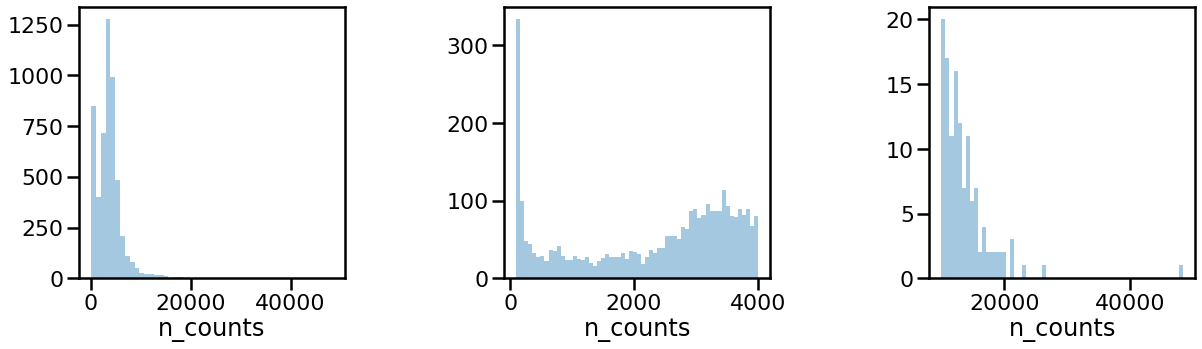

In [25]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

Histograms of the number of counts per cell show a small peak of groups of cells with fewer than 1000 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 15,000 counts. We estimate this population to range until 20,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

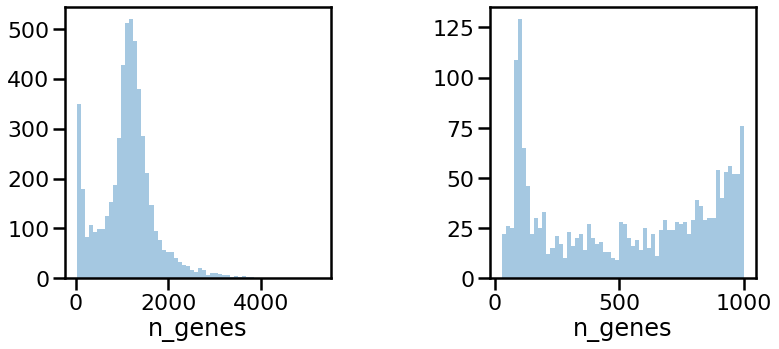

In [26]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

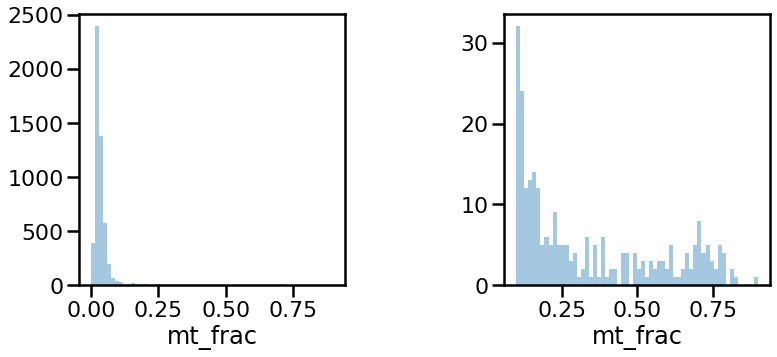

In [27]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.

In [28]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 5301
filtered out 820 cells that have less than 1000 counts
Number of cells after min count filter: 4481
filtered out 7 cells that have more than 20000 counts
Number of cells after max count filter: 4474
Number of cells after MT filter: 4470
filtered out 274 cells that have less than 700 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 4196


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [29]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 33694
filtered out 21415 genes that are detected in less than 20 cells
Number of genes after cell filter: 12279


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Doublet score

Let us estimate the amount of doublets in the dataset.

In [30]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 48.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 4.6 seconds


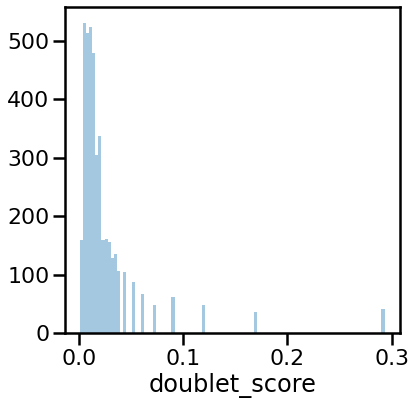

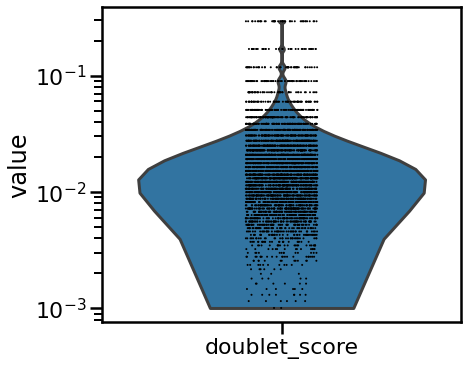

In [31]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()


sc.pl.violin(adata, 'doublet_score',
                  size=2, log=True, cut=0)

### filtering doublets

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

In [32]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 3804


### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object. 

In [33]:
adata.obs['batch'] = '1'

df = adata.obs[['n_genes','n_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['n_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['n_counts'].apply(np.median).values
df_all

mean_genes  median_genes  mean_counts  median_counts
batch                                                       
1      1312.656151        1231.5  4268.637695         3831.0

In [34]:
df_all.to_csv(table_dir + 'data_overview.csv')

## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Ideally, we want to apply the `scran` library size normalization followed by log-transformation. However, `scran` is again an R package, and we use the simpler normalisation to logCPM, `i.e.` we divide by the library size followed by the log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

**Comment:** For `scran`, we have not (comprehensively) tested whether normalisation per sample or all samples jointly gives more accurate results. When we normalised per sample, observed many more differentially expressed genes across conditions (in the range of thousands). We think that normalisation per sample preserves a systematic bias while joint normalisation removes batch effects within the same cluster partially, if a cluster contains cell from several batches. No such effect of the normalisation can be observed when samples do not overlap at all. For the time being, we perform joint normalisation of all samples. 

In [35]:
adata.layers['counts'] = adata.X.copy()

We use the logCPM normalisation: Normalise with the library size and log-scale.

In [36]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


... storing 'batch' as categorical


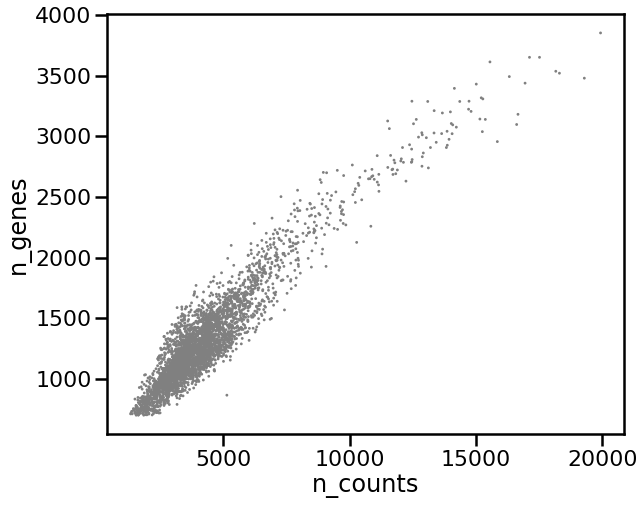

In [37]:
# Visualize the estimated size factors
rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata,  'n_counts', 'n_genes')


## Batch correction - general remarks

This dataset consists of a single batch, thus, batch effect correction is not an issue here. If you handle several batches, you may observe differences across samples, for instance, in the library size per dataset. Such differences may contribute to the batch effect. [Büttner et al., Nat Meth (2019)](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`). 

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), Harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

Several benchmarking studies aimed to determine best performing methods. In simple cases, Seurat v3 and Harmony performed best [Tran et al., Genome Biology (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9) and [Chazarra-Gil et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111211v2). More complex scenarios have been benchmarked in [Luecken et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2), where BBKNN, Scanorama, and scVI performed well. Furthermore, Scanorama had high scores in the preservation of biological signals, while BBKNN tended to overcorrect. Moreover, Luecken et al. tested different pre-processing schemes. In general, **selecting highly variable genes prior to batch correction improved the batch effect correction result**. We continue with the selection of highly variable genes. 


## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [38]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


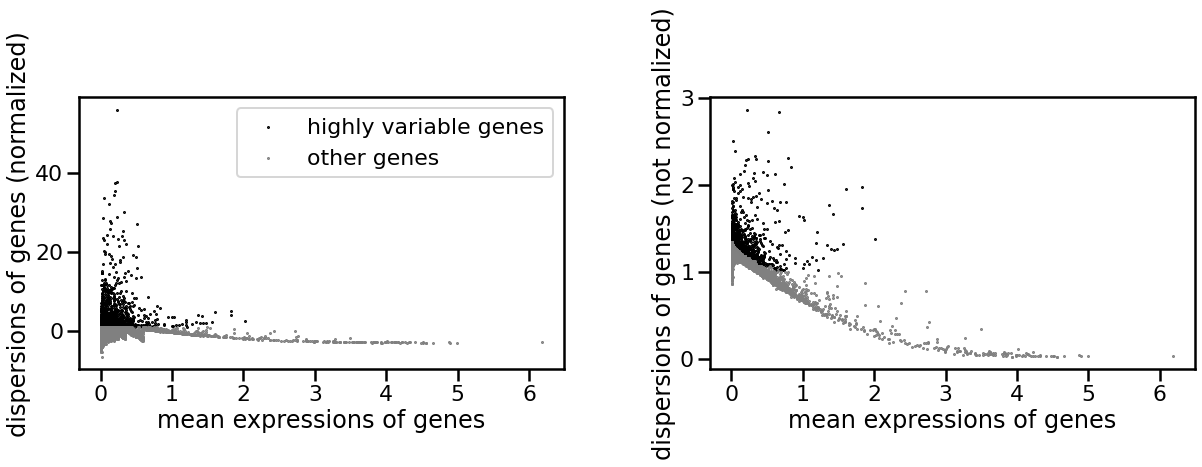

In [39]:
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data as layer 'counts' in adata
* log-scran normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

We will look at several visualizations to decide which visualization best represents the aspect of the data.

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [40]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


To determine the number of informative principal components, let us review the variance contribution of each component. 

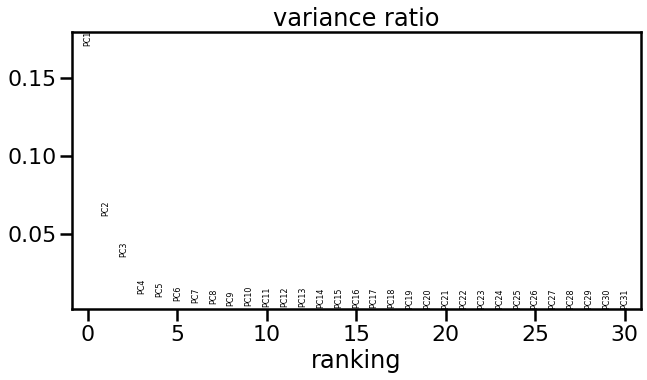

In [41]:
sc.pl.pca_variance_ratio(adata)

Using the elbow method, we select the first 4 PCs as informative.

In [42]:
sc.pp.pca(adata, n_comps=4, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

    on highly variable genes
computing PCA with n_comps = 4
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 4
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing tSNE
    using 'X_pca' with n_pcs = 4
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99992925 0.99970776 0.998524   0.9965432  0.99534553
     0.9892818  0.9861788  0.9845242  0.98416066 0.9780825  0.97267175
     0.9723705  0.9632557  0.96094465]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (ad

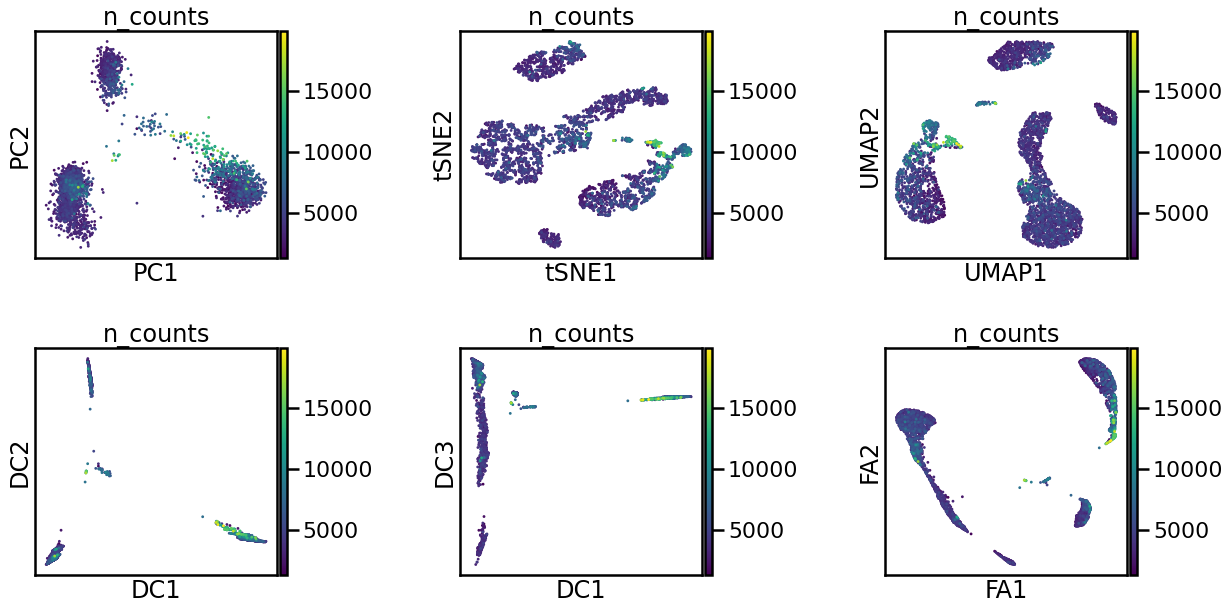

In [43]:
rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, gene lists from [Macosko et al., Cell 161 (2015)](https://www.sciencedirect.com/science/article/pii/S0092867415005498) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [scIB github repository](https://github.com/theislab/scib/tree/master/scIB/resources/).

Please note, that the gene list was generated for human HeLa cells.

In [44]:
s_genes_file = data_dir + 's_genes_tirosh_hm.txt'
g2m_genes_file = data_dir + 'g2m_genes_tirosh_hm.txt'

In [45]:
s_genes = pd.read_table(s_genes_file, header = None).values.flatten()
g2m_genes = pd.read_table(g2m_genes_file, header = None).values.flatten()

In [46]:
s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

Compute cell cycle score.

In [47]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [48]:
print(len(s_genes_hvg))
print(len(g2m_genes_hvg))

28
26


In [49]:
adata.obs['phase'].value_counts()

G1     1591
G2M    1234
S       979
Name: phase, dtype: int64

Let us check whether MKI67 is present in the dataset.

In [50]:
sum(adata.var_names == 'MKI67')

1

... storing 'phase' as categorical


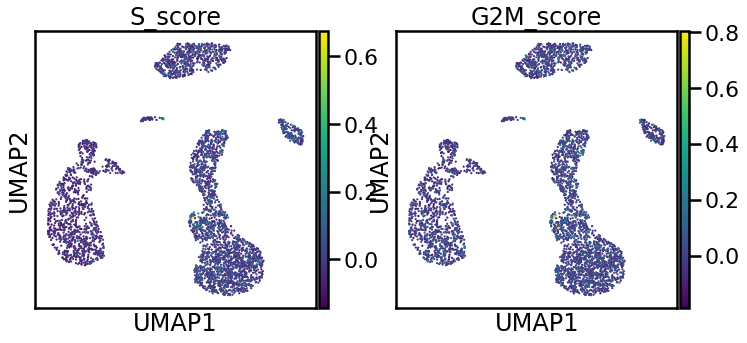

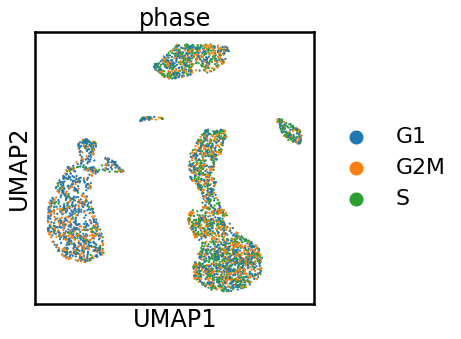

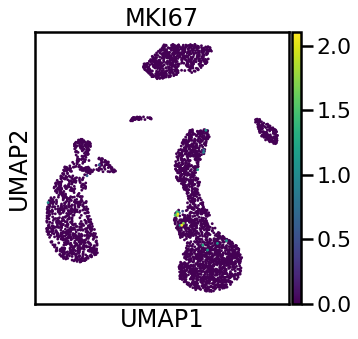

In [51]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=20, use_raw=False)
sc.pl.umap(adata, color=['phase'], size=20, use_raw=False)
#a classical interphase marker (which is not present in this dataset, unfortunately, is MKI67)
sc.pl.umap(adata, color='MKI67')

Apparently, all cells are assigned to the same proliferative cell cycle phase (G2M), but inspecting the interface marker MKI67 shows little evidence for proliferation. If the phase score looks suspicious, one has to adjust the threshold for assigning a certain phase. By default, a cell is G1, if both S and G2M score are negative. Otherwise, a cell is assigned to the phase where it has the highest score. Potentially, we would need to adapt the cutoffs of the classification.

At this point of the analysis, we have reached an important milestone as we finished the pre-processing and enter the downstream analysis part. **Ideally, we don't have to revisit this part again.**

In [52]:
adata.write(data_dir + 'data_processed.h5ad')

# Downstream analysis

In [53]:
adata = sc.read(data_dir + 'data_processed.h5ad')

## Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section).

Compute a `louvain` clustering with two different resolutions (`0.5` and `1.5`). Compare the clusterings in a table and visualize the clustering in an embedding. Optional: Compute a clustering with the `leiden` algorithm. 

In [54]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, resolution=1.5, key_added='louvain_r1.5')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [55]:
pd.crosstab(adata.obs['louvain_r0.5'], adata.obs['louvain_r1.5'])

louvain_r1.5    0    1    2    3    4    5    6  ...   10   11   12  13   14  15  16
louvain_r0.5                                     ...                                
0             416    0    0    0    0  275    0  ...  184    0    0   0    0   0   0
1               0    0    0  316    0    0  273  ...    0    0    0   0    0  31   0
2               0  383    0    0    0    0    0  ...    0    0    0   0    0   0   0
3               0    0    0    0  290    0    0  ...    0    0    0   0    0   0   0
4               0    0    0    0    0    0    0  ...    0  165    0  55  108  50   0
5               0    0  367    0    0    0    0  ...    0    0    0   0    0   0   0
6               0    0    0    0    0    0    0  ...    0    0  152   0    0   0   0
7               0    0    0    0    0    0    0  ...    0    0    0  62    0   0  36

[8 rows x 17 columns]

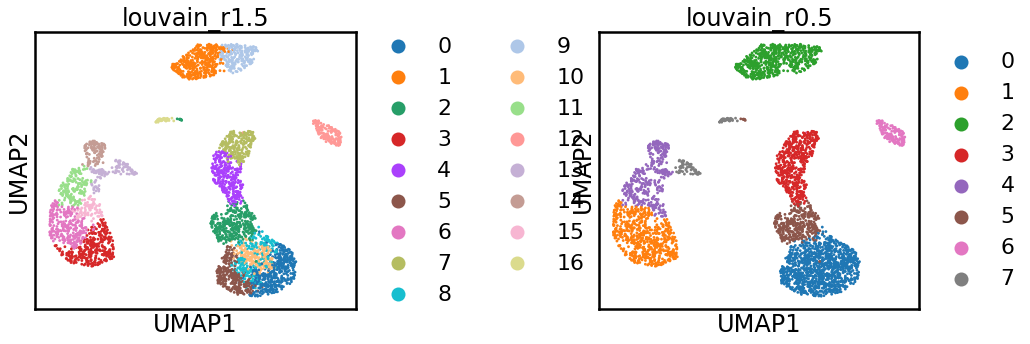

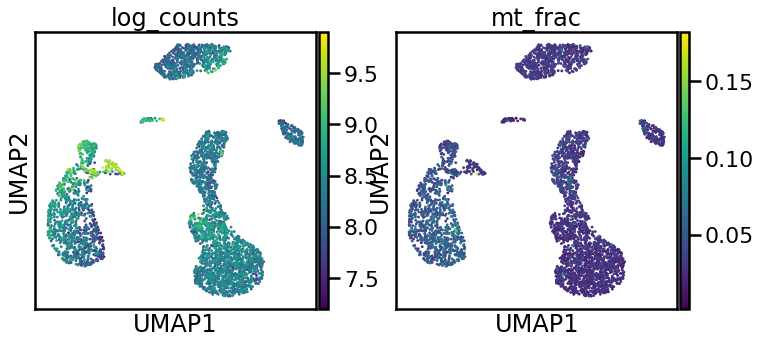

In [56]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1.5', 'louvain_r0.5'], wspace=0.6)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

## Marker genes and cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

As we are using the relevant mouse gut atlas from the literature in this case study, there is no other reference atlas which we use to annotate the cells by automated annotation. Thus, we do not use scmap or garnett here.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [57]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


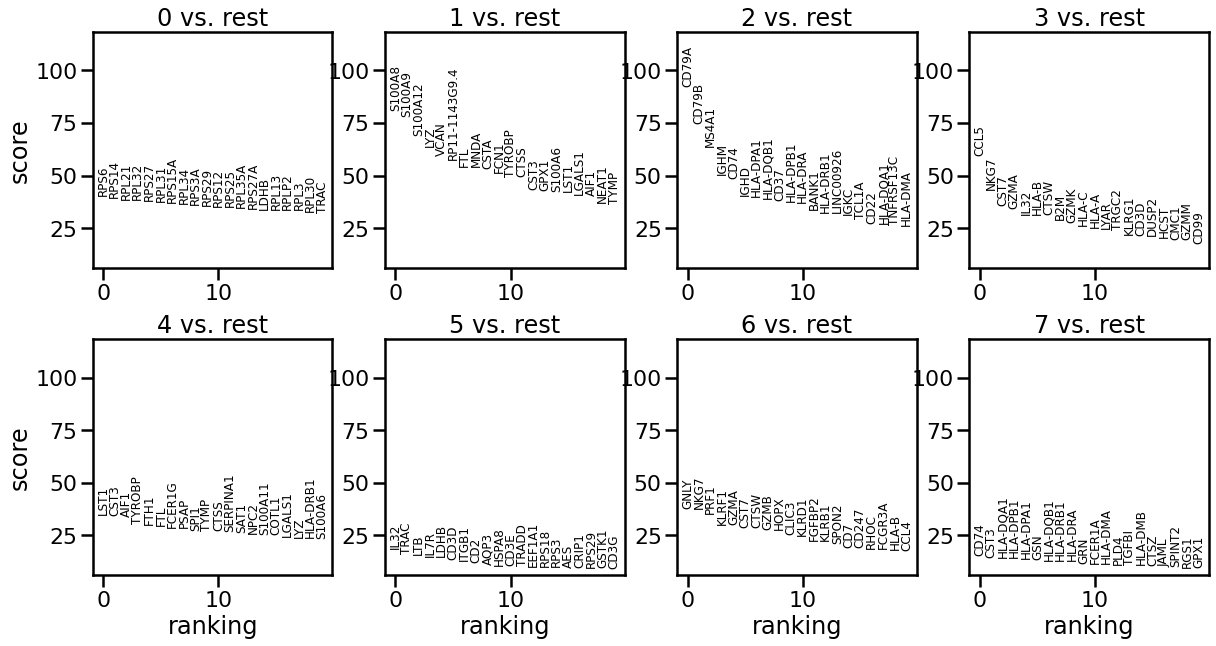

In [58]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)

In [59]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1.5', key_added='rank_genes_r1.5')

ranking genes
    finished: added to `.uns['rank_genes_r1.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


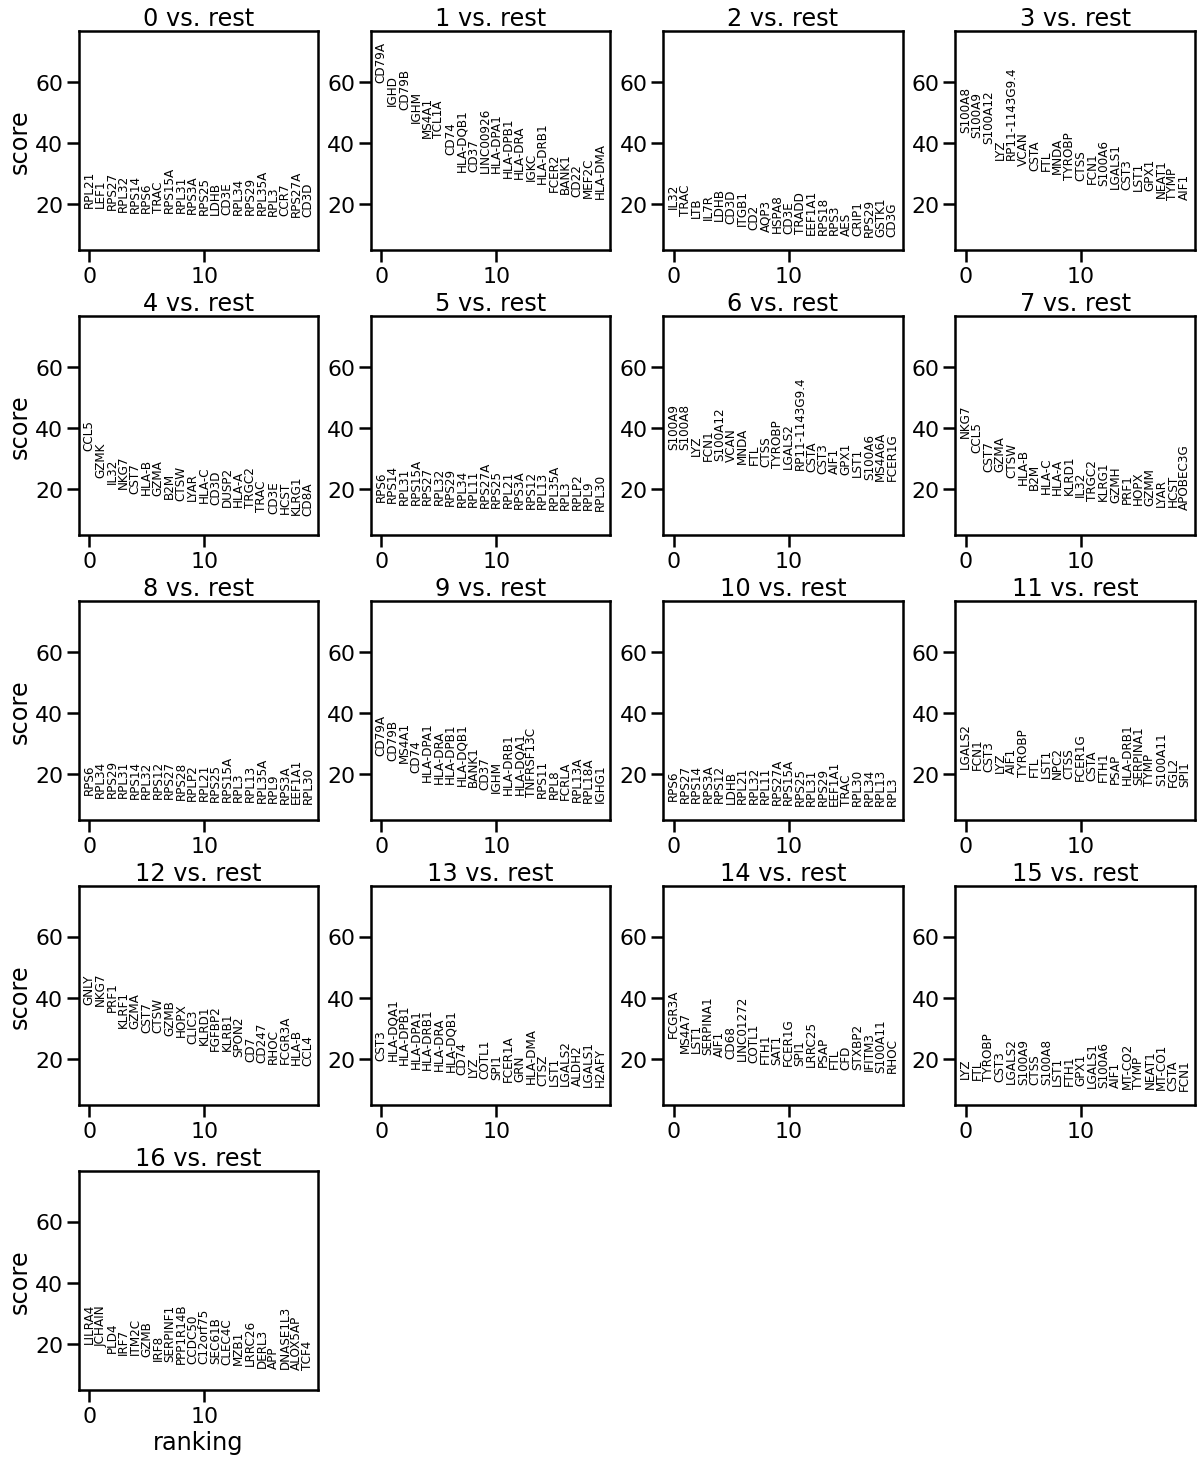

In [60]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1.5', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search. In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets. 

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [61]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Annotate the clusters. You can use auxilliary plots like `matrixplot`, `dotplot`,`heatmap` or `violin` plots or coloring an embedding by the marker genes.

Let us check if the marker genes are expressed in our dataset.

In [62]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

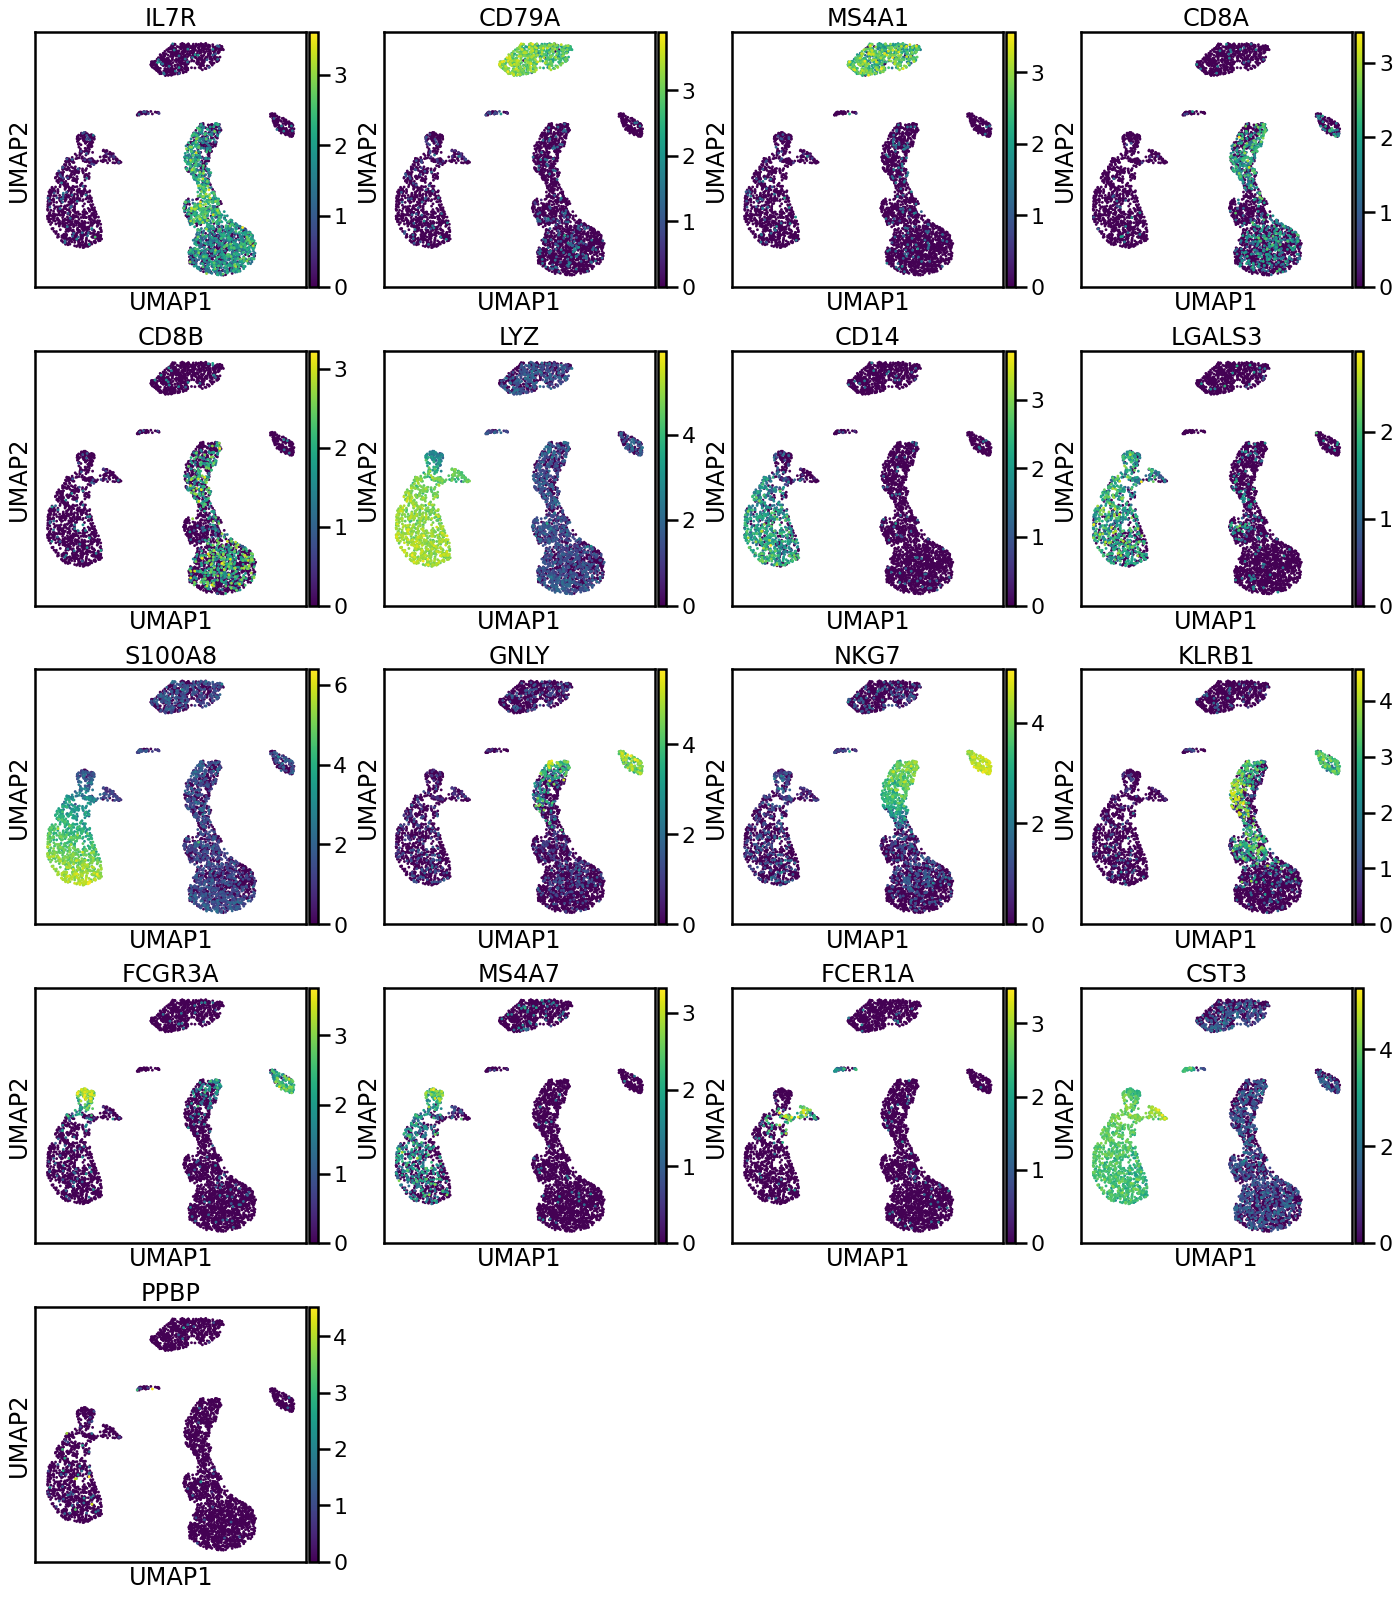

In [63]:
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

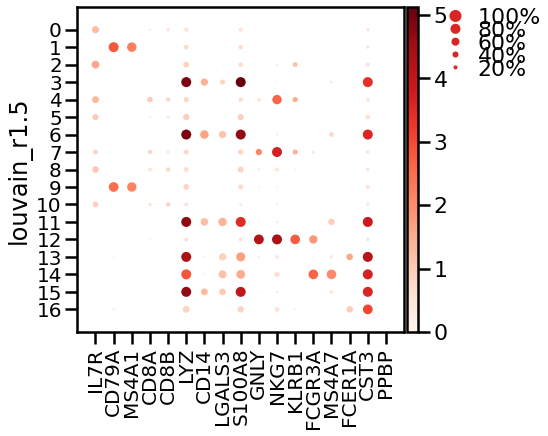

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[5.949999999999999, 0, 0.2, 0.5, 0.25])

In [64]:
sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1.5', use_raw=False)

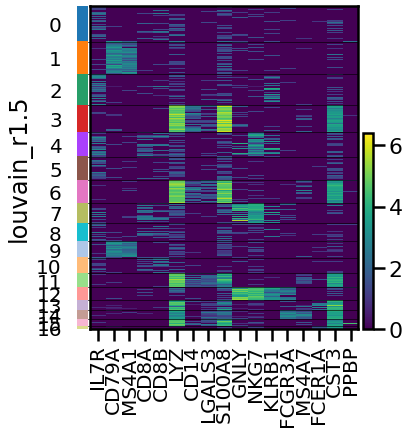

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.1, 0, 0.2])

In [65]:
sc.pl.heatmap(adata=adata, var_names=marker_genes,
              groupby='louvain_r1.5', use_raw=False, vmin=0)

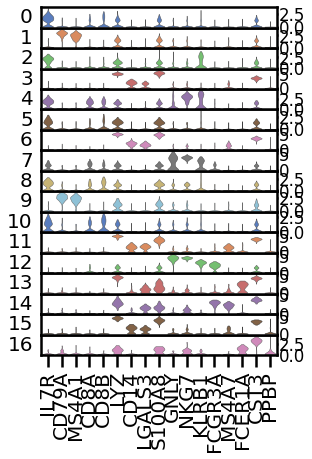

In [66]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1.5', use_raw=False)

Annotate clusters and create a new covariate.


|Cluster ID|Marker Gene|Cell Type|
|---------|-------|-------|
|0,2|IL7R|CD4 T cells|
|3,6,11,15|CD14, LYZ|CD14+ Monocytes|
|1,9|MS4A1|B cells|
||CD8A|CD8 T cells|
|14|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|7,12|GNLY, NKG7|NK cells|
|13,16|FCER1A, CST3|Dendritic Cells|
|none|PPBP|Megakaryocytes|

Use the `pandas` data frame functionality to rename your clusters and visualize your annotation.

In [67]:
adata.obs['annotated'] = adata.obs['louvain_r1.5'].cat.add_categories(['CD4 T cells', 
                        'CD14+ Monocytes', 'B cells', 'CD8 T cells', 
                        'FCGR3A+ Monocytes', 'NK cells', 'Dendritic cells'])

adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['0','2','8','10'])] = 'CD4 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3','6','11','15'])] = 'CD14+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1','9'])] = 'B cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['4','5'])] = 'CD8 T cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['14'])] = 'FCGR3A+ Monocytes'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7', '12'])] = 'NK cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['13','16'])] = 'Dendritic cells'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [68]:
adata.obs['annotated'].value_counts()

CD4 T cells          1181
CD14+ Monocytes       835
B cells               575
CD8 T cells           565
NK cells              387
Dendritic cells       153
FCGR3A+ Monocytes     108
Name: annotated, dtype: int64

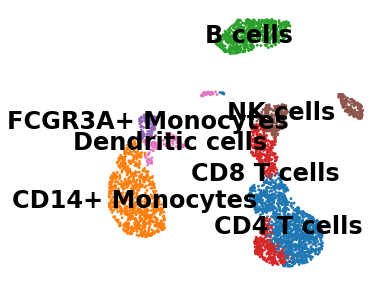

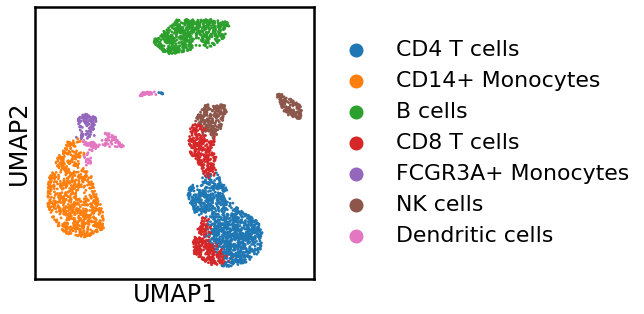

In [69]:
sc.pl.umap(adata, color='annotated', legend_loc='on data', title='', frameon=False)
sc.pl.umap(adata, color='annotated',  title='', frameon=True)

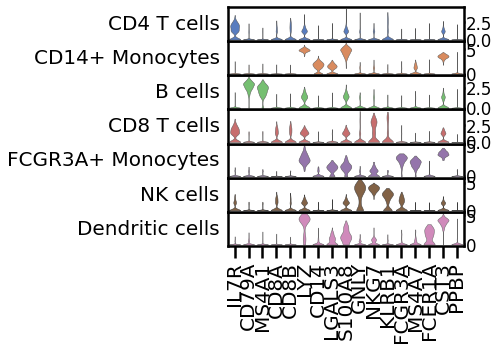

In [70]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='annotated', use_raw=False)

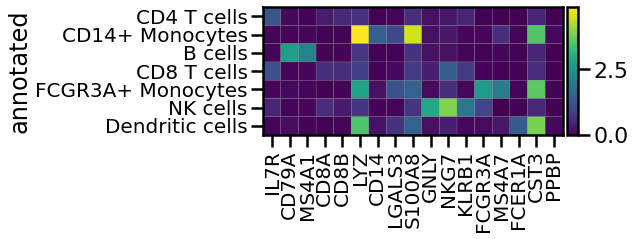

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[5.44, 0, 0.2])

In [71]:
sc.pl.matrixplot(adata, marker_genes, groupby='annotated', use_raw=False, vmin=0)

### Inspect subpopulations of B cells

Let us determine the differences in the B cell clusters by differential expression. Subcluster the B cells first.

In [72]:
sc.tl.louvain(adata, resolution=0.2, restrict_to = ['annotated',['B cells']], key_added='louvain_R')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


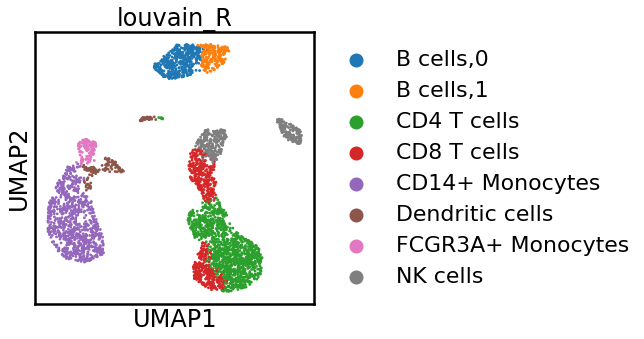

In [73]:
rcParams['figure.figsize']= (5,5)
sc.pl.umap(adata, color='louvain_R')

In [74]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_R', groups= ['B cells,1'], 
                        reference='B cells,0', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


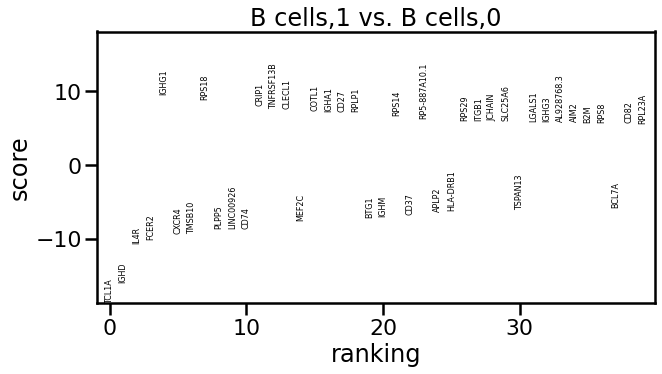

In [75]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata, size=10, n_genes=40)

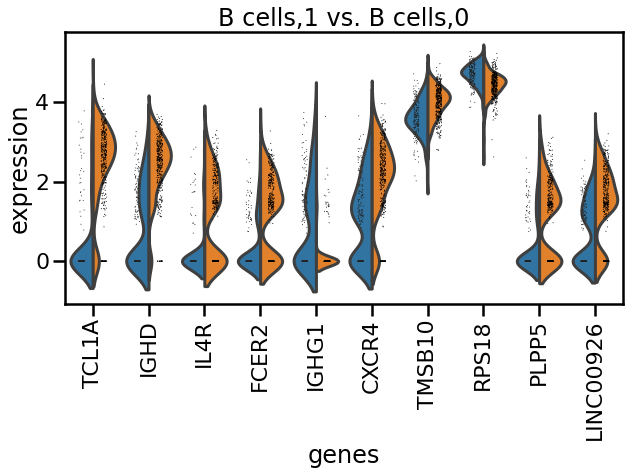

In [76]:
sc.pl.rank_genes_groups_violin(adata, groups='B cells,1', n_genes=10, use_raw=False)

Here, the B cell populations differ in B cell activation markers such as TCL1A and IL4R. 
Potentially, `B cells,0` are activated B cells and `B cells,1` are resting, but we have to look at more markers to make the distinction. 

### Compute a PAGA for PBMCs

We aim to find relations between the respective cell types based on the knn graph with partition-based graph abstraction (PAGA). 

Compute PAGA on the cluster annotation and plot the graph (note: use the plot function `paga_compare`).

In [77]:
sc.tl.paga(adata = adata, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


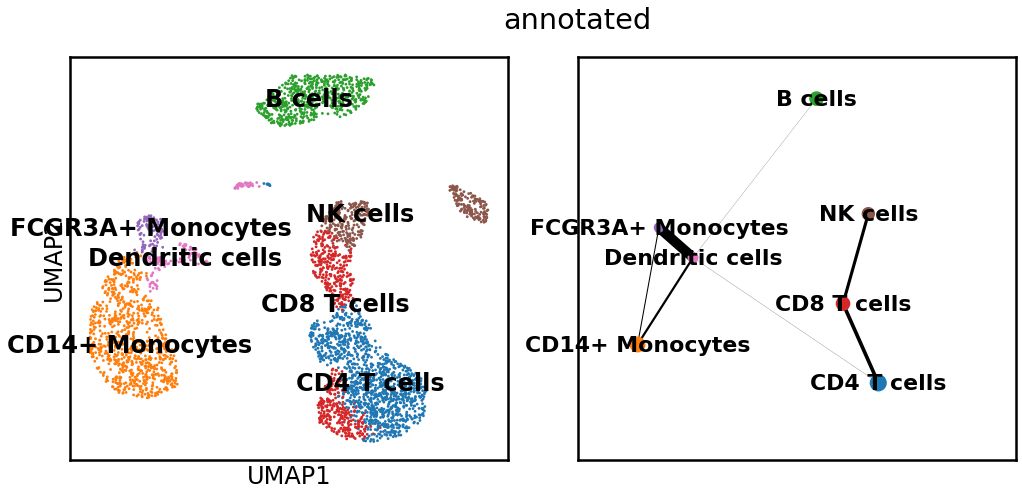

In [78]:
rcParams['figure.figsize']=(7,7)
sc.pl.paga_compare(adata = adata, basis='umap', frameon=True)

## Save annotated data to file

At this point, we have finished the data annotation. This represents another milestone in the data analysis of single cell data. Once the annotation is finished, we won't have to touch this part of the analysis again.   

In [79]:
adata.write(data_dir + 'data_processed.h5ad')

## Pseudotime on Monocytes

In this section, we want to explore a potential transition of CD14+ and FCGR3A+ Monocytes.

In [80]:
adata = sc.read(data_dir + 'data_processed.h5ad')

Select the monocytes.

In [81]:
adata_mono = adata[np.in1d(adata.obs['annotated'], 
                           ['CD14+ Monocytes', 'FCGR3A+ Monocytes'])].copy()

In [82]:
adata_mono

AnnData object with n_obs × n_vars = 943 × 12279 
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'doublet', 'batch', 'S_score', 'G2M_score', 'phase', 'louvain_r1.5', 'louvain_r0.5', 'annotated', 'louvain_R'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotated_colors', 'annotated_sizes', 'diffmap_evals', 'draw_graph', 'louvain', 'louvain_R_colors', 'louvain_r0.5_colors', 'louvain_r1.5_colors', 'neighbors', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'rank_genes_r0.5', 'rank_genes_r1.5', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

Compute a diffusion pseudotime (DPT). Note: Fix a root cell as `adata.uns['iroot']` first. Visualize the pseudotime on the embedding. Compute the differentially expressed genes between the two subgroups and visualize the expression of 20 top differentially expressed genes along pseudotime.

In [83]:
sc.tl.pca(adata_mono, svd_solver='arpack')
sc.pp.neighbors(adata_mono)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


Convert UMAP indices to arrays.

In [84]:
umap_0 = [term[0] for term in adata_mono.obsm['X_umap']]
umap_1 = [term[1] for term in adata_mono.obsm['X_umap']]

Set root cell to the cell with the smallest value in the first UMAP component and compute DPT.

In [85]:
adata_mono.uns['iroot'] = np.flatnonzero(umap_1== max(umap_1))[0]
sc.tl.dpt(adata = adata_mono)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


Visualise DPT on a UMAP and on a diffusion map.

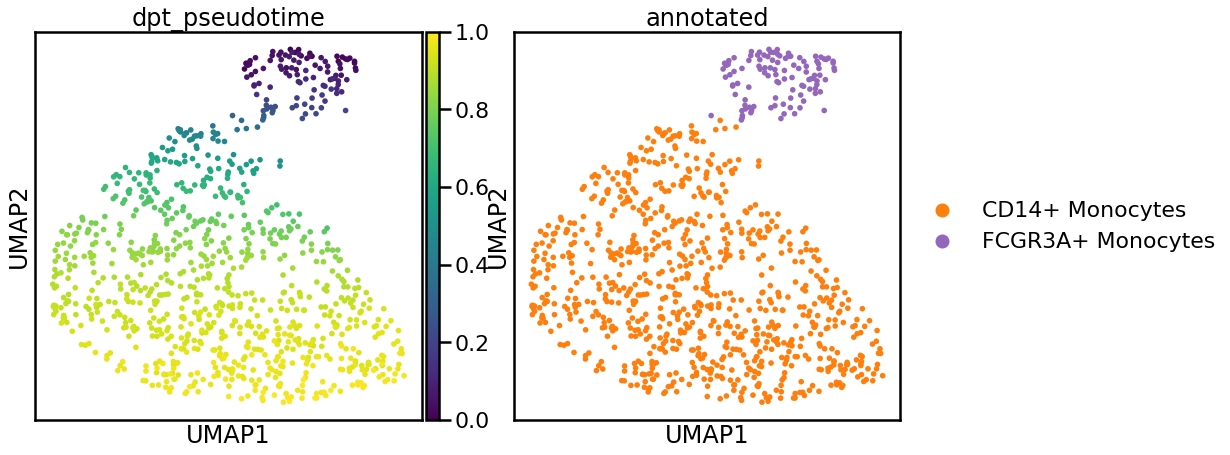

In [86]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_mono, color=['dpt_pseudotime', 'annotated'])

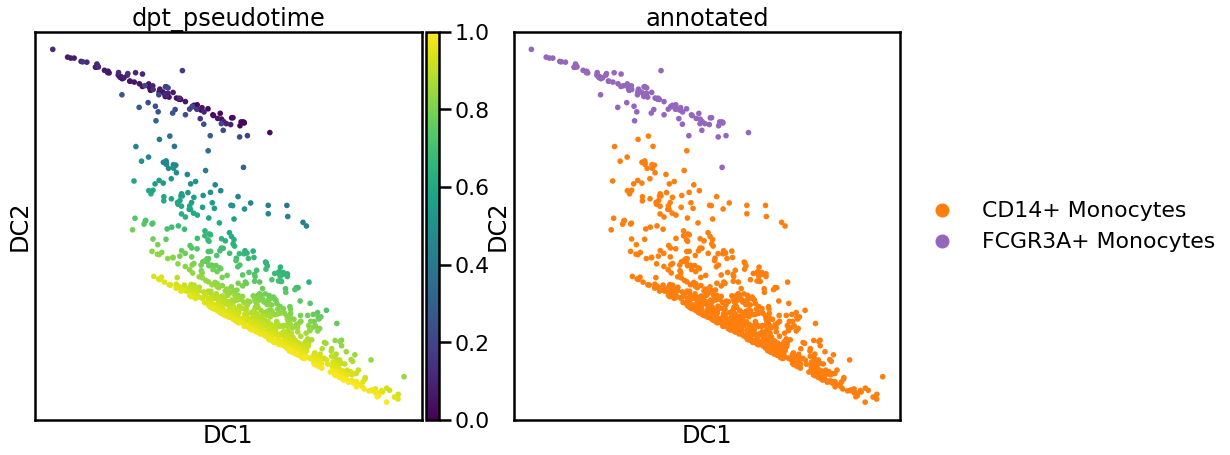

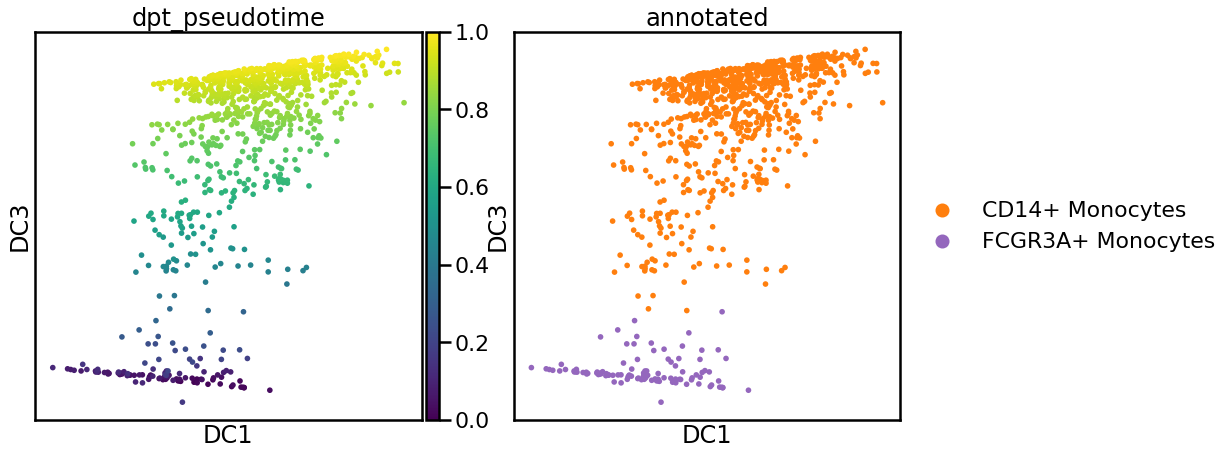

In [87]:
rcParams['figure.figsize']=(7,7)
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['1,2'])
sc.pl.diffmap(adata_mono, color=['dpt_pseudotime', 'annotated'], components=['1,3'])

Run a differential test on the two groups of monocytes in order to determine characteristic genes.  

In [88]:
sc.tl.rank_genes_groups(adata_mono, groupby='annotated', 
                        groups= ['FCGR3A+ Monocytes'], reference='CD14+ Monocytes', rankby_abs=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


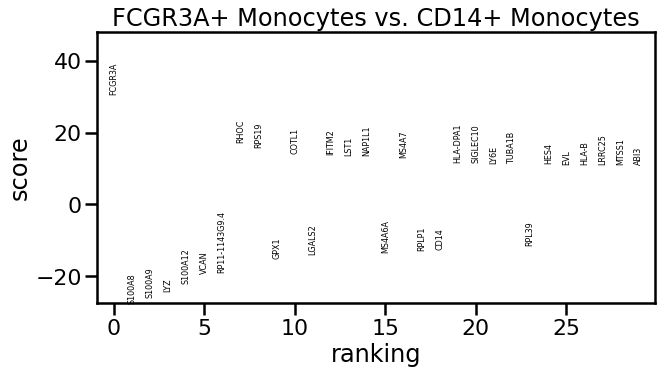

In [89]:
rcParams['figure.figsize']=(10,5)
sc.pl.rank_genes_groups(adata_mono, size=10, n_genes=30)

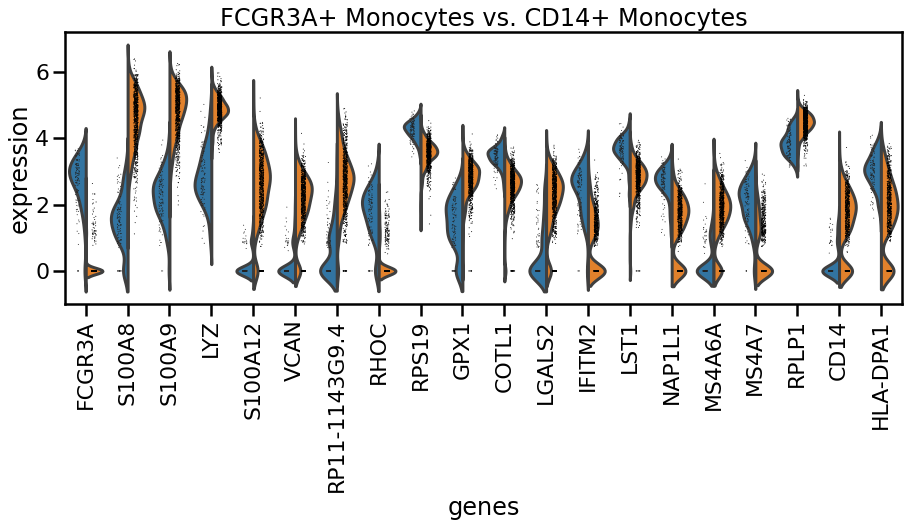

In [90]:
rcParams['figure.figsize']= (15,5)
sc.pl.rank_genes_groups_violin(adata_mono, use_raw=False)

In [91]:
mono_genes = [idx[1][0] for idx in enumerate(adata_mono.uns['rank_genes_groups']['names'])]


In order to visualise the gene expression along pseudotime, we have to compute PAGA for the two groups of monocytes.

In [92]:
sc.tl.paga(adata_mono, groups='annotated')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


Modify the format of the data matrix, because `paga_path` takes only dense matrices (in this `scanpy` version).

In [93]:
adata_mono.X = adata_mono.X.todense()

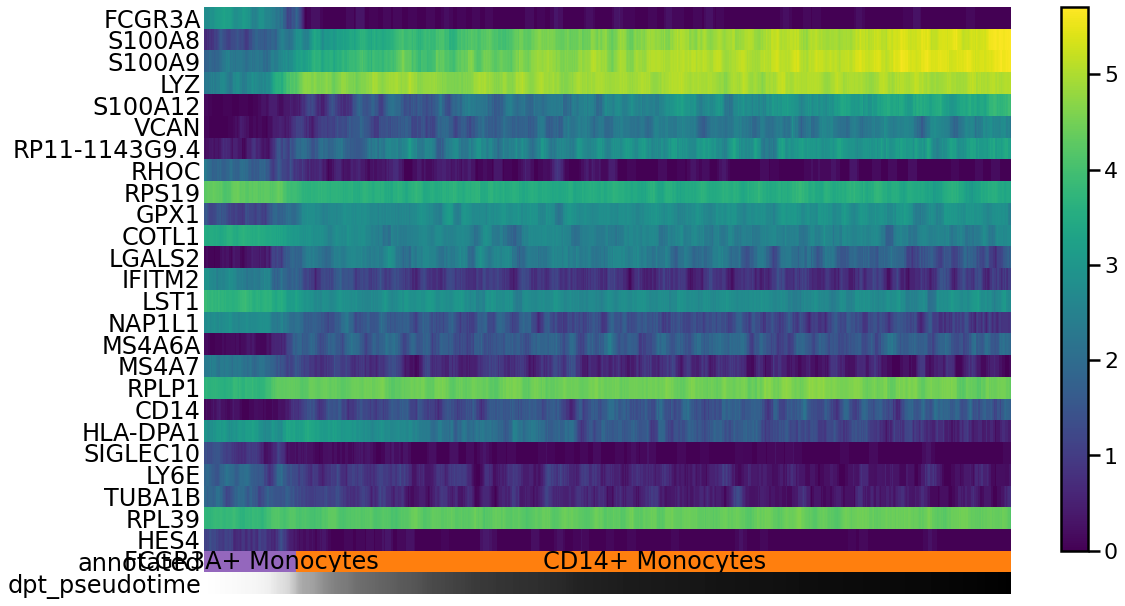

In [94]:
rcParams['figure.figsize']=(20,10)
sc.pl.paga_path(adata_mono, nodes=['FCGR3A+ Monocytes','CD14+ Monocytes'], 
                keys=mono_genes[:25],n_avg=10, use_raw=False, save='_monocyte_transition.pdf')